## Matplotlib limitations

Let's start by importing the tools we need: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0xdeadbeef)

Then we create a sample of (x,y) points. In this sample, 100 points are drawn from a Gaussian distribution centred at (0,0) with a width of 1. On top of this, we add 100 points drawn from another Gaussian distribution centred at (1,1), with a width of 0.05. 

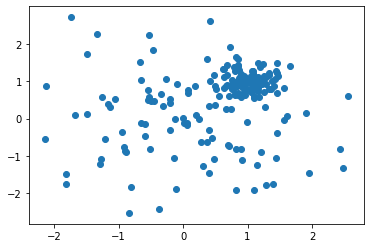

In [2]:
sample1 = np.random.multivariate_normal([0,0], [[1,0],[0,1]], 100)
sample2 = np.random.multivariate_normal([1,1], [[0.05,0],[0,0.05]], 100)
sample = np.concatenate([sample1, sample2])
plt.scatter(sample[:,0],sample[:,1])

Since the number of points is not too large, we clearly see the two distributions. But let's add more points now. 

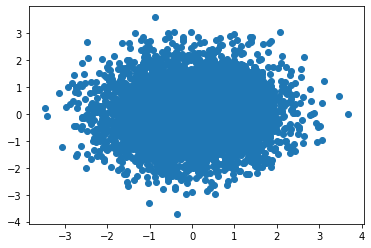

In [3]:
sample1 = np.random.multivariate_normal([0,0], [[1,0],[0,1]], 5000)
sample2 = np.random.multivariate_normal([1,1], [[0.05,0],[0,0.05]], 5000)
sample = np.concatenate([sample1, sample2])
plt.scatter(sample[:,0],sample[:,1])

And we just get a blob of mess, no way to see the two distributions. Of course, it's possible to tune our plotting options: 

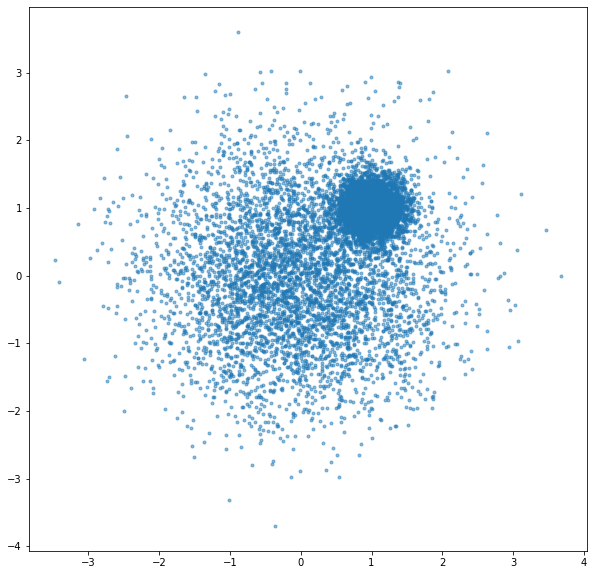

In [4]:
plt.figure(figsize=(10,10))
plt.scatter(sample[:,0],sample[:,1], alpha=0.5, marker='.')

That's much nicer! 

Still, the plot is static. No way to zoom nor to get some information on these points. That's where bokeh will really help. 

## First visualization with bokeh

Let's import some tools from bokeh and initialize it: 

In [5]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

Then, we can do a simple plot with the following code. 
What is very nice is that we can now hover on the data to get some information, and do a box zoom to focus on part of the data. 

In [6]:
tools = "hover, box_zoom, undo, crosshair"
p = figure(tools=tools)
p.scatter(sample[:,0], sample[:,1], alpha=0.5)
show(p)

## Bokeh and pandas

The integration between bokeh and pandas works very well. In this section, we will use pandas to add another value to each data point, and we will see how to modify the bokeh tooltip to show this value while hovering. 

First we're going to import: 

* pandas: we will create a pandas dataframe from the numpy array holding our sample, so that we can add a new value to each point. 
* the bokeh ColumnDataSource: it will act as a convenient interface beteween bokeh and the dataframe. 
* the bokeh HoverTool: we'll need it to change the format of the tooltip

In [7]:
from bokeh.models import ColumnDataSource, HoverTool
import pandas as pd 

Then, we create the dataframe from our sample, and we print the first rows:

In [8]:
df = pd.DataFrame(sample, columns=('x','y'))
df.head()

,x,y
0,0.849694,1.881592
1,0.394075,0.958888
2,-1.749096,-0.054847
3,0.859521,-0.815819
4,-0.772113,-0.605808


Let's now add a new value to each point, and print again. As an example, I put here the distance of the point from origin, but this value could be anything; it does not have to be a function of x and y. 

In [9]:
df['value'] = np.sqrt(df['x']**2 + df['y']**2)
df.head()

,x,y,value
0,0.849694,1.881592,2.064550
1,0.394075,0.958888,1.036707
2,-1.749096,-0.054847,1.749955
3,0.859521,-0.815819,1.185047
4,-0.772113,-0.605808,0.981408


And finally, we do another plot, with a custom HoverTool: 

In [10]:
source = ColumnDataSource(df)
tools = "box_zoom, undo, crosshair"
p = figure(tools=tools)
p.scatter('x','y', source=source, alpha=0.5)
p.add_tools(
    HoverTool(
        tooltips=[('value','@value{2.2f}'), 
                  ('index', '@index')]
    )
)
show(p)

Using the index given by the tooltip, we can locate the corresponding row in the dataframe: 

In [13]:
df.loc[1034]

x        2.075677
y        3.030386
value    3.673101
Name: 1034, dtype: float64

## Bokeh Graphical User Interface

Now that we master the basics, let's try something a bit more involved. We will do the exact same plot but this time, the user will be able to click a button to add a number of points to the sample. 

In [15]:
from bokeh.layouts import grid
from bokeh.models import Button, TextInput

def modify_doc(doc):
    # same as before
    source = ColumnDataSource(df)
    p = figure(tools=tools)
    p.scatter('x','y', source=source, alpha=0.5)
    p.add_tools(
        HoverTool(
            tooltips=[('value','@value{2.2f}'), 
                      ('index', '@index')]
        )
    )
    
    # this function is called when the button is clicked
    def update():
        # number of points to be added, taken from input text box
        n = int(npoints.value)
        # new sample of points to be added. 
        # we use the a narrow gaussian centred on (-1, 1), 
        # and draw the requested number of points
        sample3 = np.random.multivariate_normal([-1,-1], [[0.05,0],[0,0.05]], n)
        df_new = pd.DataFrame(sample3, columns=('x','y'))
        df_new['value'] = np.sqrt(df['x']**2 + df['y']**2)
        # only the new data is streamed to the bokeh server, 
        # which is an efficient way to proceed
        source.stream(df_new)
    
    # GUI: 
    button = Button(label='add points:')
    npoints = TextInput(value="50")
    button.on_click(update)
    # arranging the GUI and the plot. 
    layout = grid([[button, npoints], p])
    doc.add_root(layout)

show(modify_doc)

I obtained the plot above after editing the number of points to add 500 points everytime I click the "add points: " button, and clicking this button twice. 